In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from subprocess import check_output
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

In [2]:
df = pd.read_csv('../data/master_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2246 non-null   float64
 1   text                     2246 non-null   object 
 2   favorites                2246 non-null   int64  
 3   retweets                 2246 non-null   int64  
 4   date                     2246 non-null   object 
 5   tweet_datetime           2246 non-null   object 
 6   date_part                2246 non-null   object 
 7   time_part                2246 non-null   object 
 8   hour                     2246 non-null   int64  
 9   year                     2246 non-null   int64  
 10  month                    2246 non-null   int64  
 11  text_topic_modelling     2197 non-null   object 
 12  text_EDA                 2246 non-null   object 
 13  text_sentiment_analysis  2212 non-null   object 
 14  text_LSTM               

## Sentiment Analysis

In [24]:
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text_sentiment_analysis'].astype(str).apply(sid.polarity_scores)
df['compound'] = [i['compound'] for i in df['sentiment_score']]
df = df.drop(['sentiment_score'], axis=1)

df

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,...,text_LSTM,60mins_price_diff_abs,60mins_price_diff_perc,45mins_price_diff_abs,45mins_price_diff_perc,30mins_price_diff_abs,30mins_price_diff_perc,15mins_price_diff_abs,15mins_price_diff_perc,compound
0,9.353400e+17,Thank you Rand! https://t.co/NvPeleVmub,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,...,thank you rand,0.385000,0.001475,0.115000,0.000440,-0.010000,-0.000038,0.050000,0.000191,0.4199
1,8.997980e+17,"Join me live from Fort Myer in Arlington, Virg...",36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,...,join me live from fort myer in arlington virginia,0.590000,0.002421,0.590000,0.002421,-0.090000,-0.000369,-0.040000,-0.000164,0.2960
2,8.939700e+17,Thank you Nicole! https://t.co/KlWN05uFOx,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,...,thank you nicole,0.065000,0.000271,0.015000,0.000063,0.085000,0.000354,0.065000,0.000271,0.4199
3,8.819770e+17,Thank you to Shawn Steel for the nice words on...,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,...,thank you to shawn steel for the nice word on,0.142857,0.000603,0.096000,0.000405,0.130000,0.000549,0.035000,0.000148,0.6486
4,8.787250e+17,MAKE AMERICA GREAT AGAIN!,134210,36346,2017-06-24 21:23:00,2017-06-25 05:23:00,2017-06-25,05:23:00,5,2017,...,make america great again,0.005714,0.000023,0.004286,0.000018,0.002857,0.000012,0.001429,0.000006,0.6588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,9.990960e+17,If the person placed very early into my campai...,78529,20098,2018-05-23 01:13:00,2018-05-23 09:13:00,2018-05-23,09:13:00,9,2018,...,if the person placed very early into my campai...,0.890000,0.003284,0.618700,0.002283,0.480000,0.001771,0.070000,0.000258,0.6792
2242,9.874600e+17,So General Michael Flynn’s life can be totally...,93569,25259,2018-04-20 10:34:00,2018-04-20 18:34:00,2018-04-20,18:34:00,18,2018,...,so general michael flynn s life can be totally...,0.205000,0.000768,0.165000,0.000618,0.130000,0.000487,0.070000,0.000262,-0.6689
2243,9.870960e+17,"My thoughts, prayers and condolences are with ...",62645,16081,2018-04-19 22:30:00,2018-04-20 06:30:00,2018-04-20,06:30:00,6,2018,...,my thought prayer and condolence are with the ...,0.450000,0.001675,0.590000,0.002196,0.620000,0.002308,0.290000,0.001080,0.6900
2244,9.863570e+17,Today’s Court decision means that Congress mus...,56749,12426,2018-04-17 21:34:00,2018-04-18 05:34:00,2018-04-18,05:34:00,5,2018,...,today s court decision mean that congress must...,0.095000,0.000351,0.026667,0.000099,-0.048000,-0.000177,0.110000,0.000407,-0.9493


## Topic Modelling

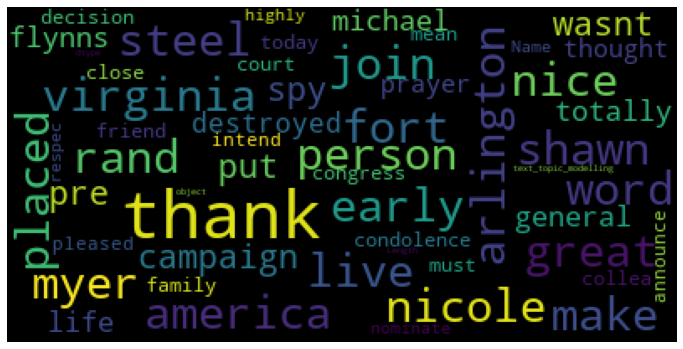

In [25]:
stop_words = set(stopwords.words('english')).union({'amp', 'nan'})

plt.rcParams['figure.figsize'] = (12.0,12.0)  
plt.rcParams['font.size'] = 12            
plt.rcParams['savefig.dpi'] = 100             
plt.rcParams['figure.subplot.bottom'] = .1 
wordcloud = WordCloud(background_color='black',
                      stopwords=stop_words,
                      max_words=500,
                      max_font_size=40, 
                      random_state=100
                      ).generate(str(df.text_topic_modelling))
print(wordcloud)
#fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_words(df.text_topic_modelling.values.astype('U'), 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

In [27]:
print(unigram)

    unigram  count
0     great    629
1        wa    314
2    people    259
3        ha    249
4   country    233
5     thank    214
6   america    191
7       job    189
8       big    174
9  american    173


In [28]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

common_words = get_top_n_trigram(df.text_topic_modelling.values.astype('U'), 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

In [29]:
print(trigram)

                trigram  count
0      fake news medium     50
1        wa great honor     45
2    make america great     42
3  making america great     24
4           kim jong un     17
5   great honor welcome     17
6        tax cut reform     15
7     love military vet     15
8     rigged witch hunt     14
9   strong crime border     14


<AxesSubplot:>

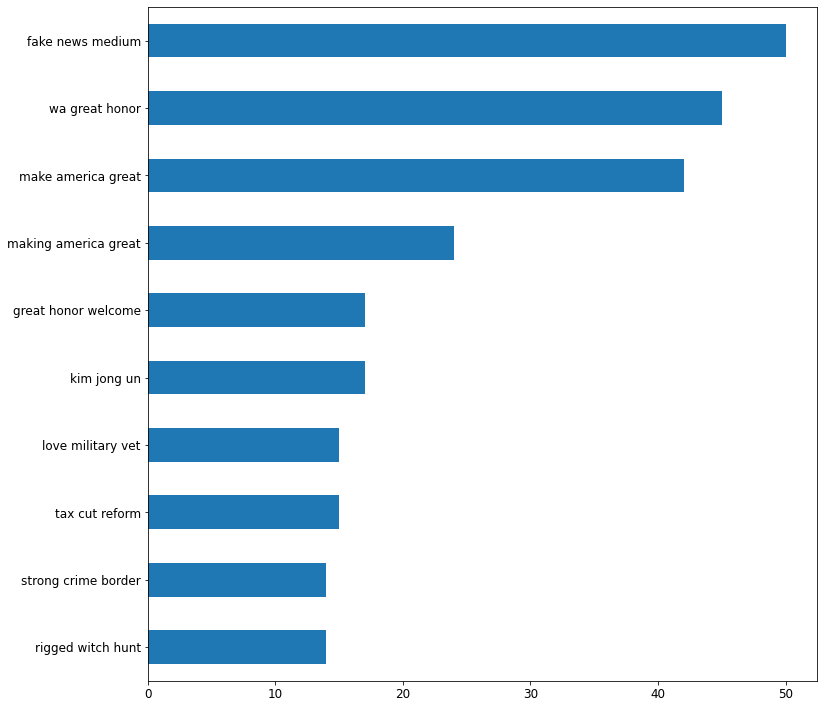

In [30]:
plotdata = pd.DataFrame({"count": list(trigram['count'])}, 
                          index = list(trigram['trigram'])).sort_values('count', ascending = True)
plotdata['count'].plot(kind="barh")

In [31]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,# minimum required occurences of a word 
                             stop_words=stop_words,# remove stop words
                             lowercase=True,# convert all words to lowercase
                             token_pattern='[a-zA-Z]{3,}',# num chars > 3
                             max_features=5000,# max number of unique words
                            )

data_matrix = vectorizer.fit_transform(df.text_topic_modelling.values.astype('U'))
data_matrix

<2246x1927 sparse matrix of type '<class 'numpy.int64'>'
	with 26786 stored elements in Compressed Sparse Row format>

In [32]:
lda_model = LatentDirichletAllocation(n_components=10, 
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1)

lda_output = lda_model.fit_transform(data_matrix)

In [33]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  17.641649
4       0.648955  71.707100       2        1  13.895779
7      71.019684   9.971006       3        1  12.745185
3       3.785981  33.185135       4        1  11.926899
8     -42.666500  -9.222070       5        1   9.741964
5      -3.621689 -43.526516       6        1   8.647540
6      -3.632402  -4.171708       7        1   8.376401
1     -36.584400  35.804413       8        1   6.869631
2      44.391380  50.615383       9        1   6.565909
9      40.235809 -31.591665      10        1   3.589043, topic_info=                Term        Freq       Total Category  logprob  loglift
704            great  589.000000  589.000000  Default  30.0000  30.0000
1706           thank  192.000000  192.000000  Default  29.0000  29.0000
1131            news  149.000000  149.000000  Default  28.0000  28.0000
64           america  180.000000  180.000000  Default  27.0000  27.0000
1726           today  153.000000  153.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
922             know   14.244800   50.186172  Topic10  -4.2650   2.0679
1130             new   15.933434  114.534045  Topic10  -4.1530   1.3548
1770           trump   13.741860  160.711165  Topic10  -4.3010   0.8681
321   congratulation    9.195108   70.813221  Topic10  -4.7028   1.2859
1229          people    8.948567  229.667315  Topic10  -4.7299   0.0821

[534 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
15        2  0.080167          across
15        8  0.881840          across
27        2  0.647288  administration
27        3  0.340678  administration
34        8  0.928920       afternoon
...     ...       ...             ...
1917      5  0.013393            year
1917      6  0.026785            year
1920      4  0.970616             yet
1921      2  0.984034            york
1922      2  0.886261           young

[749 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 8, 4, 9, 6, 7, 2, 3, 10])

In [34]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['cut', 'big', 'want', 'republican', 'people', 'great', 'tax', 'democrat', 'american', 'job']


Top 10 words for topic #1:
['service', 'join', 'woman', 'war', 'hero', 'welcome', 'honor', 'today', 'great', 'thank']


Top 10 words for topic #2:
['barrier', 'information', 'crooked', 'james', 'comey', 'tariff', 'clinton', 'hillary', 'campaign', 'fbi']


Top 10 words for topic #3:
['good', 'china', 'country', 'people', 'trade', 'get', 'billion', 'north', 'korea', 'deal']


Top 10 words for topic #4:
['working', 'world', 'forward', 'new', 'security', 'president', 'look', 'would', 'country', 'year']


Top 10 words for topic #5:
['big', 'vet', 'love', 'military', 'endorsement', 'win', 'crime', 'border', 'vote', 'great']


Top 10 words for topic #6:
['statement', 'truly', 'together', 'day', 'making', 'tonight', 'thank', 'make', 'america', 'great']


Top 10 words for topic #7:
['collusion', 'story', 'president', 'hunt', 'witch', 'russia', 'medium', 'trump', 'fake', 'ne

In [35]:
topic_values = lda_model.transform(data_matrix)
df['topic'] = topic_values.argmax(axis=1)

In [36]:
df

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,...,60mins_price_diff_abs,60mins_price_diff_perc,45mins_price_diff_abs,45mins_price_diff_perc,30mins_price_diff_abs,30mins_price_diff_perc,15mins_price_diff_abs,15mins_price_diff_perc,compound,topic
0,9.353400e+17,Thank you Rand! https://t.co/NvPeleVmub,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,...,0.385000,0.001475,0.115000,0.000440,-0.010000,-0.000038,0.050000,0.000191,0.4199,1
1,8.997980e+17,"Join me live from Fort Myer in Arlington, Virg...",36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,...,0.590000,0.002421,0.590000,0.002421,-0.090000,-0.000369,-0.040000,-0.000164,0.2960,1
2,8.939700e+17,Thank you Nicole! https://t.co/KlWN05uFOx,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,...,0.065000,0.000271,0.015000,0.000063,0.085000,0.000354,0.065000,0.000271,0.4199,1
3,8.819770e+17,Thank you to Shawn Steel for the nice words on...,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,...,0.142857,0.000603,0.096000,0.000405,0.130000,0.000549,0.035000,0.000148,0.6486,2
4,8.787250e+17,MAKE AMERICA GREAT AGAIN!,134210,36346,2017-06-24 21:23:00,2017-06-25 05:23:00,2017-06-25,05:23:00,5,2017,...,0.005714,0.000023,0.004286,0.000018,0.002857,0.000012,0.001429,0.000006,0.6588,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,9.990960e+17,If the person placed very early into my campai...,78529,20098,2018-05-23 01:13:00,2018-05-23 09:13:00,2018-05-23,09:13:00,9,2018,...,0.890000,0.003284,0.618700,0.002283,0.480000,0.001771,0.070000,0.000258,0.6792,7
2242,9.874600e+17,So General Michael Flynn’s life can be totally...,93569,25259,2018-04-20 10:34:00,2018-04-20 18:34:00,2018-04-20,18:34:00,18,2018,...,0.205000,0.000768,0.165000,0.000618,0.130000,0.000487,0.070000,0.000262,-0.6689,2
2243,9.870960e+17,"My thoughts, prayers and condolences are with ...",62645,16081,2018-04-19 22:30:00,2018-04-20 06:30:00,2018-04-20,06:30:00,6,2018,...,0.450000,0.001675,0.590000,0.002196,0.620000,0.002308,0.290000,0.001080,0.6900,8
2244,9.863570e+17,Today’s Court decision means that Congress mus...,56749,12426,2018-04-17 21:34:00,2018-04-18 05:34:00,2018-04-18,05:34:00,5,2018,...,0.095000,0.000351,0.026667,0.000099,-0.048000,-0.000177,0.110000,0.000407,-0.9493,8


In [37]:
df.to_csv('../data/master_data_SATM.csv', index=False)

## Exploratory Data Analysis

In [38]:
new = df.copy()

new

,id,text,favorites,retweets,date,tweet_datetime,date_part,time_part,hour,year,...,60mins_price_diff_abs,60mins_price_diff_perc,45mins_price_diff_abs,45mins_price_diff_perc,30mins_price_diff_abs,30mins_price_diff_perc,15mins_price_diff_abs,15mins_price_diff_perc,compound,topic
0,9.353400e+17,Thank you Rand! https://t.co/NvPeleVmub,42793,9125,2017-11-28 02:50:00,2017-11-28 10:50:00,2017-11-28,10:50:00,10,2017,...,0.385000,0.001475,0.115000,0.000440,-0.010000,-0.000038,0.050000,0.000191,0.4199,1
1,8.997980e+17,"Join me live from Fort Myer in Arlington, Virg...",36009,4891,2017-08-22 01:00:00,2017-08-22 09:00:00,2017-08-22,09:00:00,9,2017,...,0.590000,0.002421,0.590000,0.002421,-0.090000,-0.000369,-0.040000,-0.000164,0.2960,1
2,8.939700e+17,Thank you Nicole! https://t.co/KlWN05uFOx,43367,8275,2017-05-08 23:01:00,2017-05-09 07:01:00,2017-05-09,07:01:00,7,2017,...,0.065000,0.000271,0.015000,0.000063,0.085000,0.000354,0.065000,0.000271,0.4199,1
3,8.819770e+17,Thank you to Shawn Steel for the nice words on...,50956,7465,2017-03-07 20:44:00,2017-03-08 04:44:00,2017-03-08,04:44:00,4,2017,...,0.142857,0.000603,0.096000,0.000405,0.130000,0.000549,0.035000,0.000148,0.6486,2
4,8.787250e+17,MAKE AMERICA GREAT AGAIN!,134210,36346,2017-06-24 21:23:00,2017-06-25 05:23:00,2017-06-25,05:23:00,5,2017,...,0.005714,0.000023,0.004286,0.000018,0.002857,0.000012,0.001429,0.000006,0.6588,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,9.990960e+17,If the person placed very early into my campai...,78529,20098,2018-05-23 01:13:00,2018-05-23 09:13:00,2018-05-23,09:13:00,9,2018,...,0.890000,0.003284,0.618700,0.002283,0.480000,0.001771,0.070000,0.000258,0.6792,7
2242,9.874600e+17,So General Michael Flynn’s life can be totally...,93569,25259,2018-04-20 10:34:00,2018-04-20 18:34:00,2018-04-20,18:34:00,18,2018,...,0.205000,0.000768,0.165000,0.000618,0.130000,0.000487,0.070000,0.000262,-0.6689,2
2243,9.870960e+17,"My thoughts, prayers and condolences are with ...",62645,16081,2018-04-19 22:30:00,2018-04-20 06:30:00,2018-04-20,06:30:00,6,2018,...,0.450000,0.001675,0.590000,0.002196,0.620000,0.002308,0.290000,0.001080,0.6900,8
2244,9.863570e+17,Today’s Court decision means that Congress mus...,56749,12426,2018-04-17 21:34:00,2018-04-18 05:34:00,2018-04-18,05:34:00,5,2018,...,0.095000,0.000351,0.026667,0.000099,-0.048000,-0.000177,0.110000,0.000407,-0.9493,8


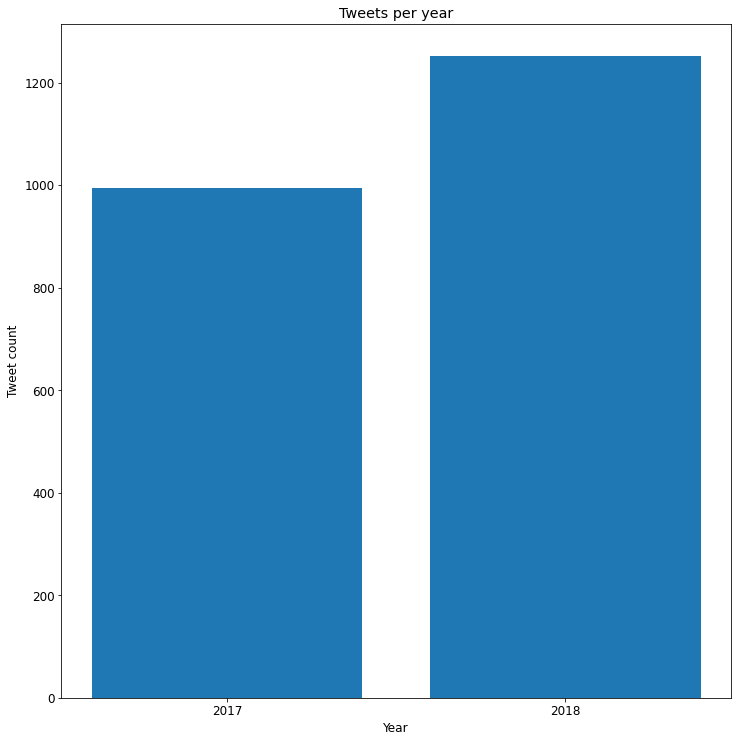

In [39]:
years = list(new['year'].astype(str).unique())
count = [list(new['year']).count(i) for i in list(new['year'].unique())]

plt.bar(years, count)
plt.xlabel('Year')
plt.ylabel('Tweet count')
plt.title('Tweets per year')
plt.show()

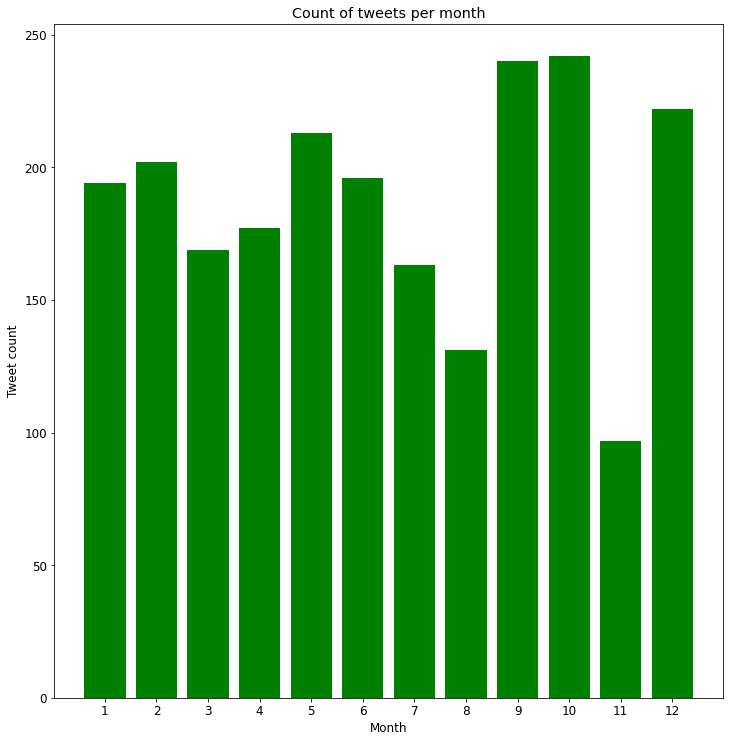

In [40]:
months = list(new['month'].sort_values(ascending=True).astype(str).unique())
count = [list(new['month']).count(i) for i in list(new['month'].unique())]

plt.bar(months, count, color='green')
plt.title('Count of tweets per month')
plt.xlabel('Month')
plt.ylabel('Tweet count')
plt.show()

In [41]:
new_2017 = new[new['year'] == 2017]
new_2018 = new[new['year'] == 2018]

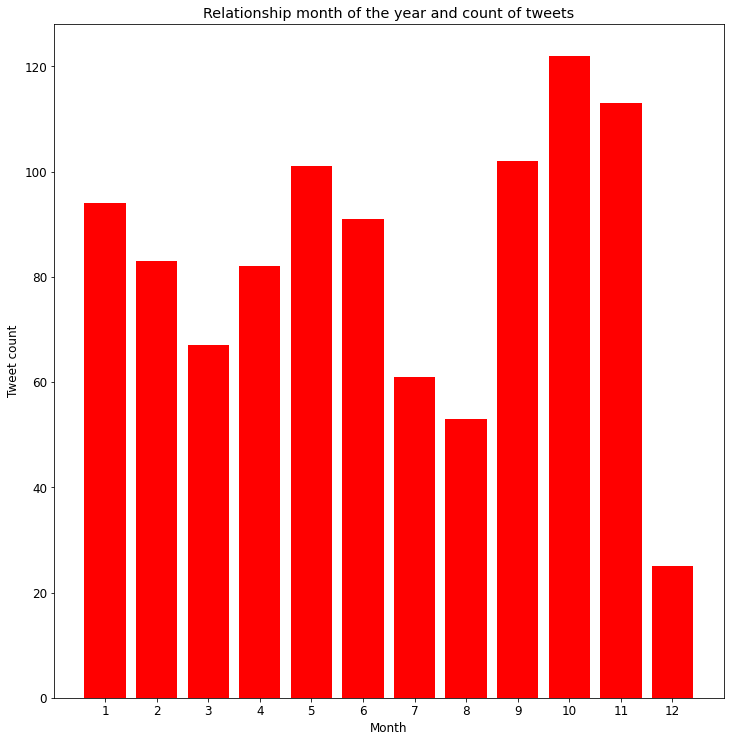

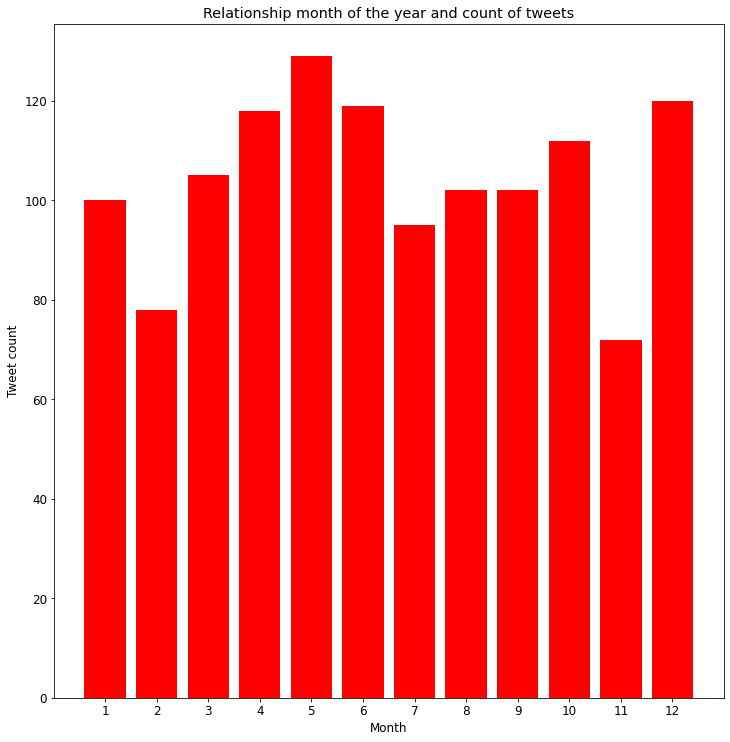

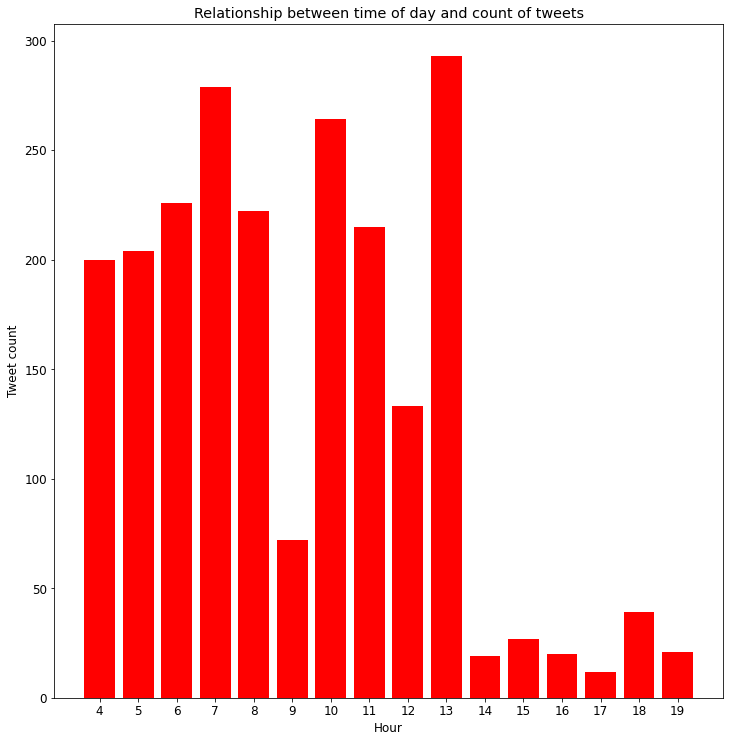

In [42]:
months = list(new_2017['month'].sort_values(ascending=True).astype(str).unique())
count = [list(new_2017['month']).count(i) for i in list(new_2017['month'].unique())]

plt.bar(months, count, color='red')
plt.title('Relationship month of the year and count of tweets')
plt.xlabel('Month')
plt.ylabel('Tweet count')
plt.show()

months = list(new_2018['month'].sort_values(ascending=True).astype(str).unique())
count = [list(new_2018['month']).count(i) for i in list(new_2018['month'].unique())]

plt.bar(months, count, color='red')
plt.title('Relationship month of the year and count of tweets')
plt.xlabel('Month')
plt.ylabel('Tweet count')
plt.show()

hours = list(new['hour'].sort_values(ascending=True).astype(str).unique())
count = [list(new['hour']).count(i) for i in list(new['hour'].unique())]

plt.bar(hours, count, color='red')
plt.title('Relationship between time of day and count of tweets')
plt.xlabel('Hour')
plt.ylabel('Tweet count')
plt.show()

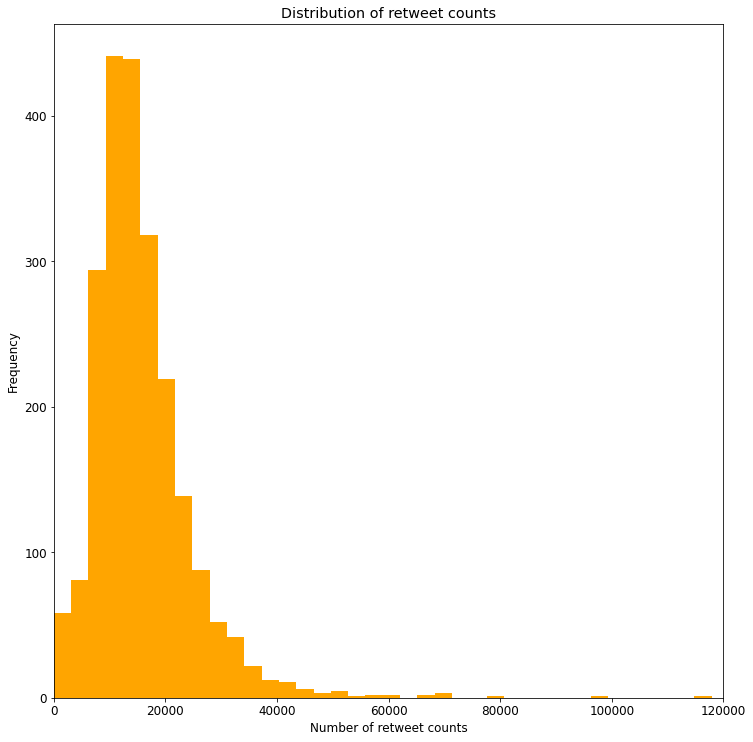

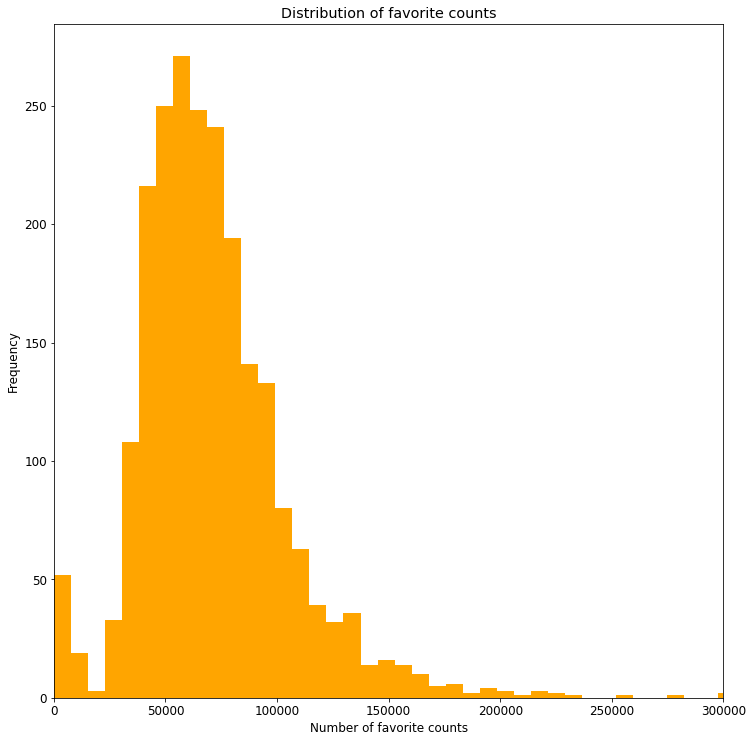

In [43]:
plt.hist(new.retweets, bins = 70, color = 'orange')
plt.xlim(left=0, right=120000)
plt.title('Distribution of retweet counts')
plt.xlabel('Number of retweet counts')
plt.ylabel('Frequency')
plt.show()

plt.hist(new.favorites, bins = 70, color = 'orange')
plt.xlim(left=0, right=300000)
plt.title('Distribution of favorite counts')
plt.xlabel('Number of favorite counts')
plt.ylabel('Frequency')
plt.show()

## Top 10 tweets with highest positive sentiments

In [44]:
top_pos = new.loc[:, ['text', '60mins_price_diff_abs', 'compound', 'topic']].sort_values(by='compound', ascending=False).head(10)

for i in range(len(top_pos)):
    print()
    print(list(top_pos['compound'])[i], ", Topic", list(top_pos['topic'])[i], "Price change", round(list(top_pos['60mins_price_diff_abs'])[i], 5))
    print(list(top_pos['text'])[i])
    print()



0.9899 , Topic 5 Price change -0.99
Congratulations to Patrick Reed on his great and courageous MASTERS win! When Patrick had his amazing win at Doral 5 years ago, people saw his great talent, and a bright future ahead. Now he is the Masters Champion!


0.9846 , Topic 1 Price change -0.15
Tonight we gathered to celebrate the courageous men and women who make freedom possible: our brave service members, and our wonderful Veterans. For 242 years, American Independence... has endured because of the sweat, blood and sacrifice of the American Armed Forces – the greatest force for peace and justice in the history of the world! 


0.9826 , Topic 4 Price change -0.00571
Thank you to all of my great supporters, really big progress being made. Other countries wanting to fix crazy trade deals. Economy is ROARING. Supreme Court pick getting GREAT REVIEWS. New Poll says Trump, at over 90%, is the most popular Republican in history of the Party. Wow!


0.9816 , Topic 1 Price change -0.05
Thank you,

## Top 10 tweets with highest negative sentiments

In [45]:
top_neg = new.loc[:, ['text', '60mins_price_diff_abs', 'compound', 'topic']].sort_values(by='compound', ascending=True).head(10)

for i in range(len(top_neg)):
    print()
    print(list(top_neg['compound'])[i], ", Topic", list(top_neg['topic'])[i], "Price change", round(list(top_neg['60mins_price_diff_abs'])[i], 5))
    print(list(top_neg['text'])[i])
    print()


-0.9736 , Topic 7 Price change 0.00038
I use Social Media not because I like to, but because it is the only way to fight a VERY dishonest and unfair “press,” now often referred to as Fake News Media. Phony and non-existent “sources” are being used more often than ever. Many stories &amp, reports a pure fiction!


-0.9735 , Topic 0 Price change 0.08667
Democrat Jon Ossoff would be a disaster in Congress. VERY weak on crime and illegal immigration, bad for jobs and wants higher taxes. Say NO


-0.9681 , Topic 9 Price change 0.00303
NYC terrorist was happy as he asked to hang ISIS flag in his hospital room. He killed 8 people, badly injured 12. SHOULD GET DEATH PENALTY!


-0.9571 , Topic 4 Price change 0.01768
All of America is in mourning over the mass murder of Jewish Americans at the Tree of Life Synagogue in Pittsburgh. We pray for those who perished and their loved ones, and our hearts go out to the brave police officers who sustained serious injuries... This evil Anti-Semitic attac

## Top 10 tweets with the highest positive price increase

In [46]:
top_pos = new.loc[:, ['text', '60mins_price_diff_abs', 'compound', 'topic']].sort_values(by='60mins_price_diff_abs', ascending=False).head(10)

for i in range(len(top_pos)):
    print()
    print(list(top_pos['compound'])[i], ", Topic", list(top_pos['topic'])[i], ", Price change", round(list(top_pos['60mins_price_diff_abs'])[i], 5))
    print(list(top_pos['text'])[i])
    print()


0.9533 , Topic 5 , Price change 2.97
Congratulations to Senator Cindy Hyde-Smith on your big WIN in the Great State of Mississippi. We are all very proud of you!


-0.3612 , Topic 8 , Price change 2.92
The reason the DACA for Wall deal didn’t get done was that a ridiculous court decision from the 9th Circuit allowed DACA to remain, thereby setting up a Supteme Court case. After ruling, Dems dropped deal - and that’s where we are today, Democrat obstruction of the needed Wall.


0.9271 , Topic 8 , Price change 2.85
Brenda Snipes, in charge of voting in Broward County, Florida, was just spotted wearing a beautiful dress with 300 I VOTED signs on it. Just kidding, she is a fine, very honorable and highly respected voting tactician!


-0.8977 , Topic 4 , Price change 2.775
Funny how lowly rated CNN, and others, can criticize me at will, even blaming me for the current spate of Bombs and ridiculously comparing this to September 11th and the Oklahoma City bombing, yet when I criticize them 

## Top 10 tweets with the highest negative price decrease

In [47]:
top_neg = new.loc[:, ['text', '60mins_price_diff_abs', 'compound', 'topic']].sort_values(by='60mins_price_diff_abs', ascending=True).head(10)

for i in range(len(top_neg)):
    print()
    print(list(top_neg['compound'])[i], ", Topic", list(top_neg['topic'])[i], ", Price change", round(list(top_neg['60mins_price_diff_abs'])[i], 5))
    print(list(top_neg['text'])[i])
    print()


0.3886 , Topic 7 , Price change -3.99
Because Jobs in the U.S. are doing so well, Americans receiving unemployment aid is the lowest since 1973. Great!


-0.9515 , Topic 7 , Price change -3.6
NBC NEWS is wrong again! They cite “sources” which are constantly wrong. Problem is, like so many others, the sources probably don’t exist, they are fabricated, fiction! NBC, my former home with the Apprentice, is now as bad as Fake News CNN. Sad!


0.0 , Topic 6 , Price change -3.58
Andy McCarthy will be on  @LouDobbs tonight. 7:00 P.M. , @FoxBusiness.


0.743 , Topic 6 , Price change -3.57
I have been briefed on the U.S. C-130 “Hercules” cargo plane from the Puerto Rico National Guard that crashed near Savannah Hilton Head International Airport. Please join me in thoughts and prayers for the victims, their families and the great men and women of the National Guard.


-0.8162 , Topic 8 , Price change -3.4625
Our Southern Border is under siege. Congress must act now to change our weak and ineffec

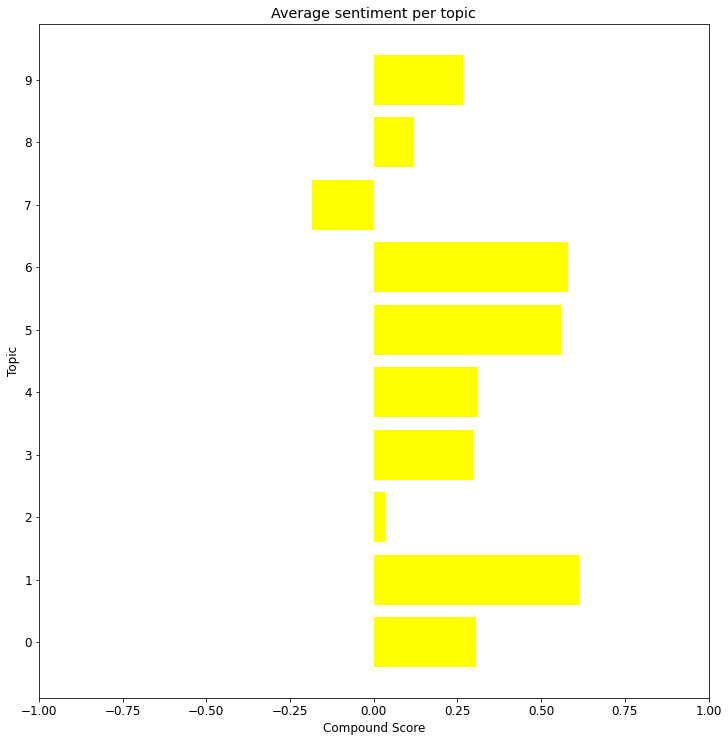

In [48]:
top_comp = new.loc[:, ['topic', 'compound']].sort_values(by='topic', ascending=True)

topics = list(top_comp['topic'].astype(str).unique())
means = []
counts = [list(top_comp['topic']).count(i) for i in list(top_comp['topic'].unique())]

for i in range(0,10):
    df = top_comp[top_comp['topic'] == i]
    sums = sum(list(df['compound']))
    means.append(sums/counts[i])
    
plt.barh(topics, means, color='yellow')
plt.title('Average sentiment per topic')
plt.xlabel('Compound Score')
plt.ylabel('Topic')
plt.xlim([-1, 1])
plt.show()    

Topic 0


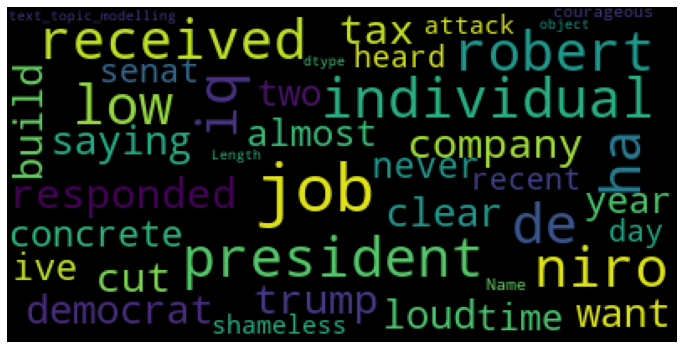

Topic 1


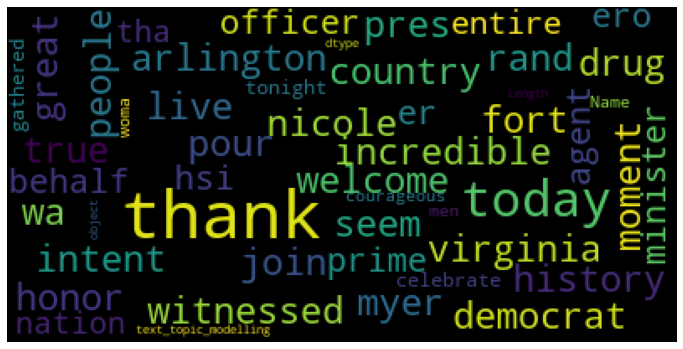

Topic 2


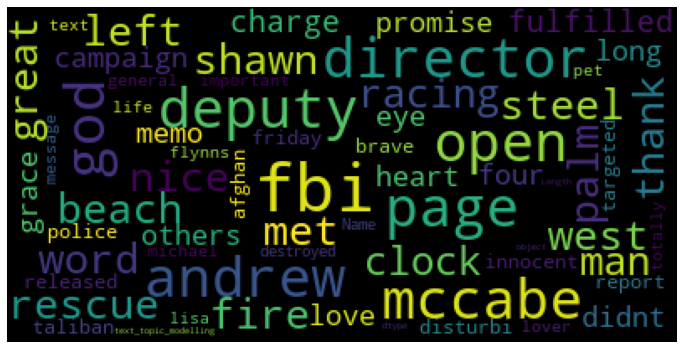

Topic 3


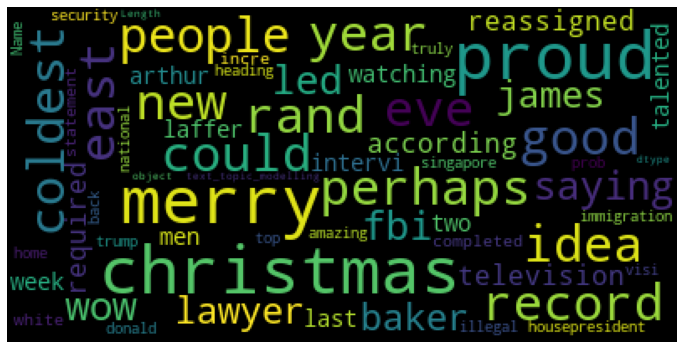

Topic 4


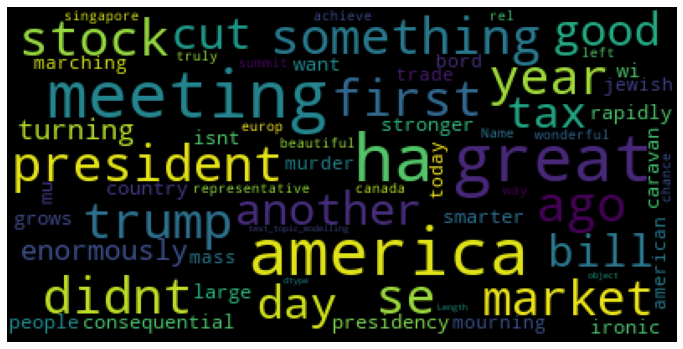

Topic 5


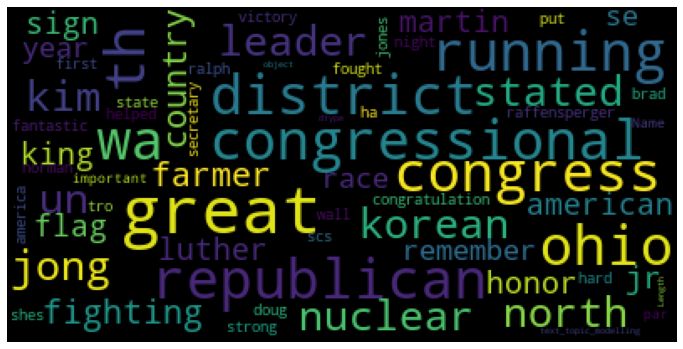

Topic 6


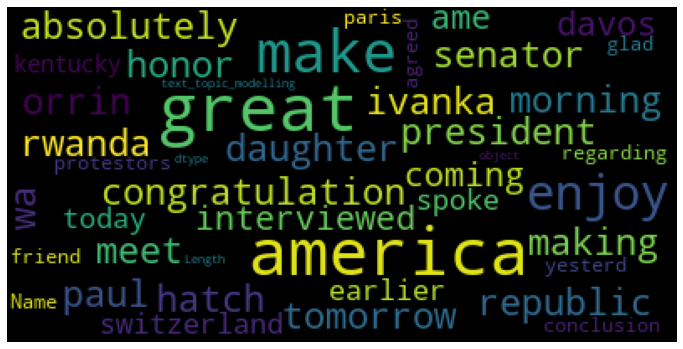

Topic 7


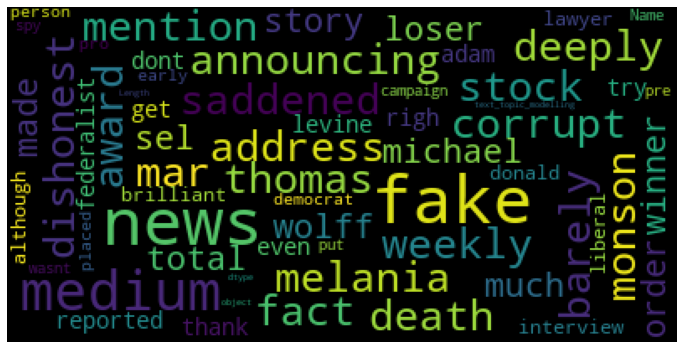

Topic 8


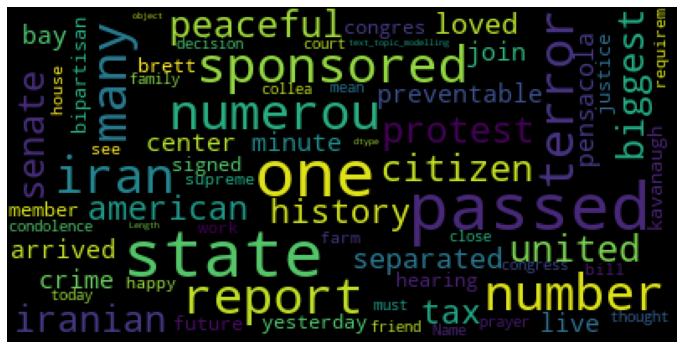

Topic 9


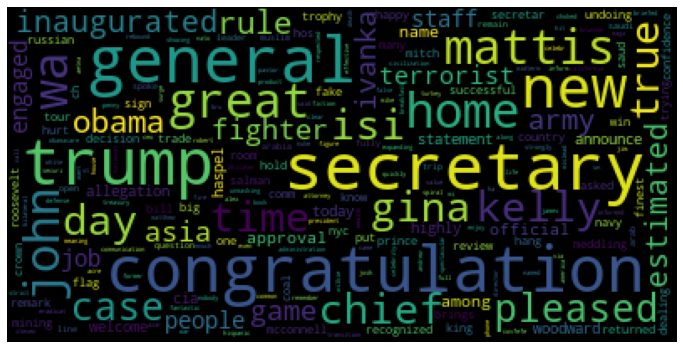

In [49]:
def generate_wordcloud(df):
    plt.rcParams['figure.figsize'] = (12.0,12.0)  
    plt.rcParams['font.size'] = 12            
    plt.rcParams['savefig.dpi'] = 100             
    plt.rcParams['figure.subplot.bottom'] = .1 
    wordcloud = WordCloud(background_color='black',
                          stopwords=stop_words,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                          ).generate(str(df.text_topic_modelling))
    print(wordcloud)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
for i in range(0,10):
    data = new[new['topic'] == i]
    print("Topic", i)
    generate_wordcloud(data)